<a href="https://colab.research.google.com/github/ericaburdett/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/assignment_213.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [5]:
# Subset df based on instructions above
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
7,2,OTHER,01 ONE FAMILY DWELLINGS,1,4090,37,NaN,A1,1193 SACKET AVENUE,NaN,10461.0,1.0,0.0,1.0,"3,404",1328.0,1925.0,1,A1,0,01/01/2019
8,2,OTHER,01 ONE FAMILY DWELLINGS,1,4120,18,NaN,A5,1215 VAN NEST AVENUE,NaN,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,01/01/2019
9,2,OTHER,01 ONE FAMILY DWELLINGS,1,4120,20,NaN,A5,1211 VAN NEST AVENUE,NaN,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,01/01/2019
42,3,OTHER,01 ONE FAMILY DWELLINGS,1,6809,54,NaN,A1,2601 AVENUE R,NaN,11229.0,1.0,0.0,1.0,"3,333",1262.0,1925.0,1,A1,0,01/01/2019
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019


In [6]:
df = df[df['SALE_PRICE'] > 100000]
df = df[df['SALE_PRICE'] < 2000000]
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [0]:
# Convert LAND_SQUARE_FEET to int

def sf_to_int(sf):
  sf = sf.replace(',', '')
  sf = int(sf)
  return sf

df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].apply(sf_to_int)

In [8]:
df['SALE_DATE'].dtypes

dtype('O')

In [0]:
# Convert df['SALE_DATE'] to datetime 
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

# Do train / test split
cutoff = pd.to_datetime('2019-04-01')
train = df[df['SALE_DATE'] < cutoff]
test = df[df['SALE_DATE'] >= cutoff]

In [10]:
# Check cardinality of non-numeric columns
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')


,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaT,NaT
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaT,NaT
BOROUGH,2507,5,4,1204,NaT,NaT
NEIGHBORHOOD,2507,7,OTHER,2360,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaT,NaT
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30
ADDRESS,2507,2497,57 CHESTNUT STREET,2,NaT,NaT


In [0]:
# Remove target column and those with high cardinality and others that aren't useful 
target = 'SALE_PRICE'
to_drop = ['BUILDING_CLASS_CATEGORY', 'APARTMENT_NUMBER', 'SALE_DATE', 'ADDRESS', 'EASE-MENT', 'TAX_CLASS_AT_TIME_OF_SALE']

features = train.columns.drop([target] + to_drop)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [0]:
# Use OneHotEncoder to encode all (useful) non-numeric features

# Import category_encoders
import category_encoders as ce

# Instantiate encoder
encoder = ce.OneHotEncoder(use_cat_names=True)

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [34]:
X_train.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,0,1,0,0,0,0,0,0,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,0,0,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,0,1,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,1,0,0,0,0,0,0,1,0,4210,19,0,1,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,0,1,0,0,0,0,0,0,0,0,0
108,1,0,0,0,0,1,0,0,0,0,0,0,1,0,5212,69,0,1,0,0,0,0,0,0,0,0,0,0,0,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,0,1,0,0,0,0,0,0,0,0,0
111,1,0,0,0,0,1,0,0,0,0,0,0,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,0,0,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,0,0,1,0,0,0,0,0,0,0,0


In [35]:
X_train.shape

(2507, 47)

In [0]:
# Select 13 features that best correlate with the target

from sklearn.feature_selection import f_regression, SelectKBest

# Instantiate class
selector = SelectKBest(score_func=f_regression, k=13)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [44]:
for k in range(1, len(X_train.columns)+1):
  print(f'{k} features')
  selector = SelectKBest(score_func = f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)
  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $183,641 

2 features
Test MAE: $179,555 

3 features
Test MAE: $179,291 

4 features
Test MAE: $179,291 

5 features
Test MAE: $178,897 

6 features
Test MAE: $177,128 

7 features
Test MAE: $171,378 

8 features
Test MAE: $171,465 

9 features
Test MAE: $170,925 

10 features
Test MAE: $167,468 

11 features
Test MAE: $167,182 

12 features
Test MAE: $166,712 

13 features
Test MAE: $156,488 

14 features
Test MAE: $157,546 

15 features
Test MAE: $157,543 

16 features
Test MAE: $157,545 

17 features
Test MAE: $157,406 

18 features
Test MAE: $157,406 

19 features
Test MAE: $157,282 

20 features
Test MAE: $157,282 

21 features
Test MAE: $152,830 

22 features
Test MAE: $152,861 

23 features
Test MAE: $152,861 

24 features
Test MAE: $152,861 

25 features
Test MAE: $152,861 

26 features
Test MAE: $152,552 

27 features
Test MAE: $152,415 

28 features
Test MAE: $152,338 

29 features
Test MAE: $152,288 

30 features
Test MAE: $153,294 

31 features
Test MA

In [0]:
# Imports
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

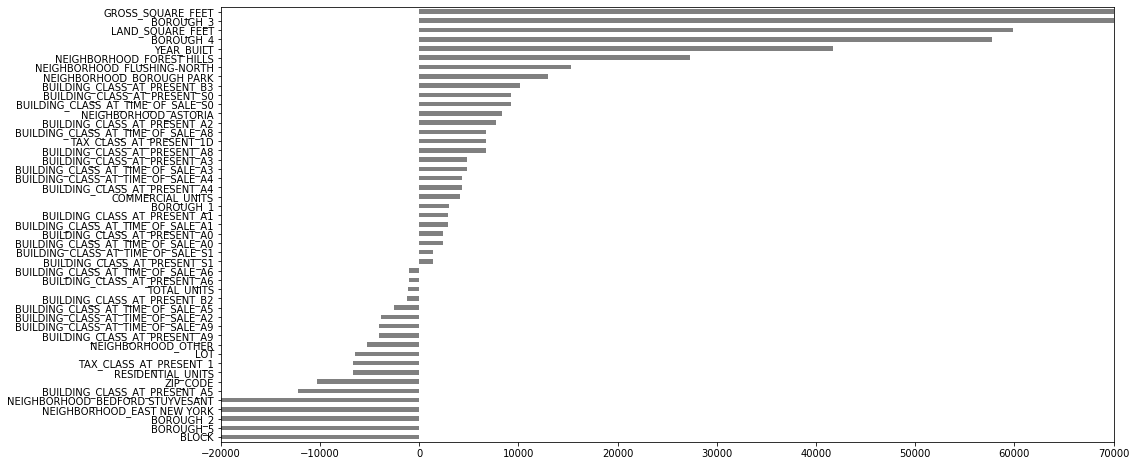

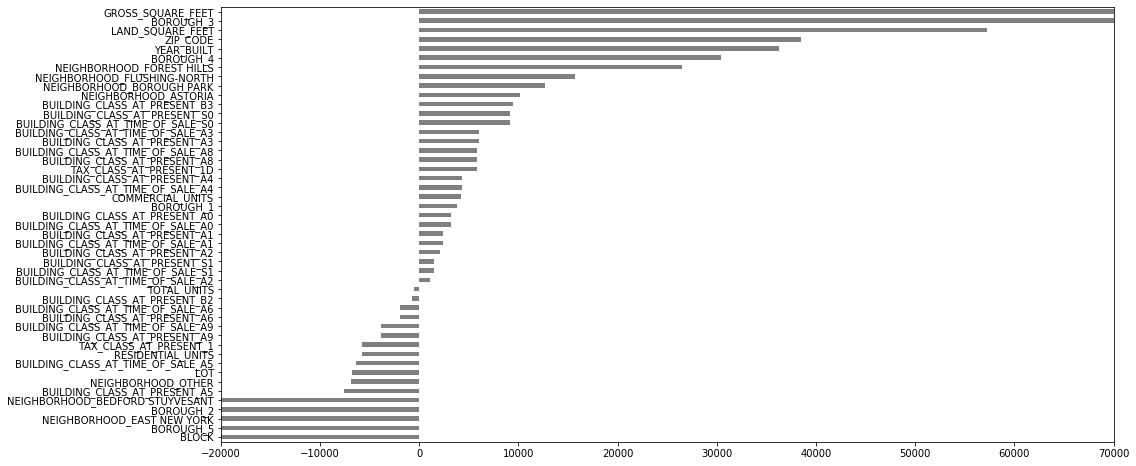

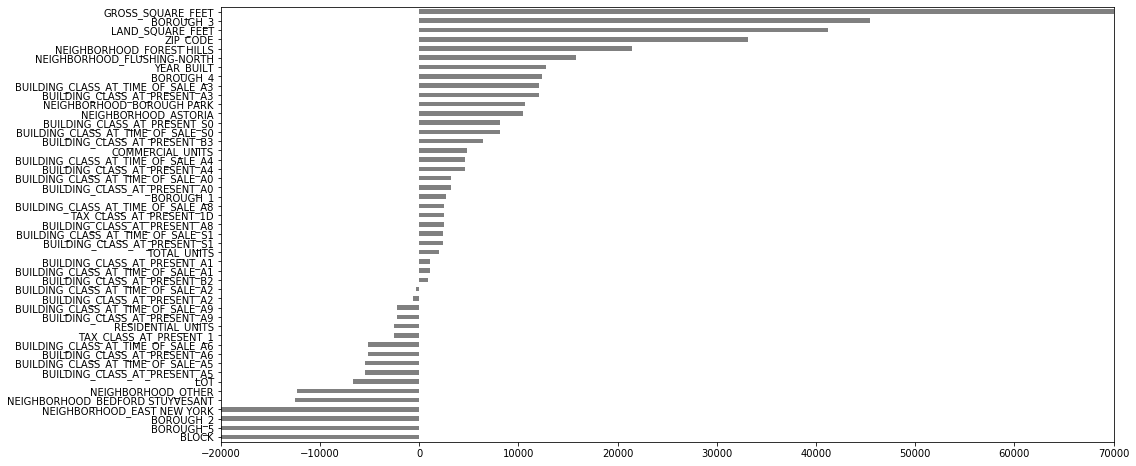

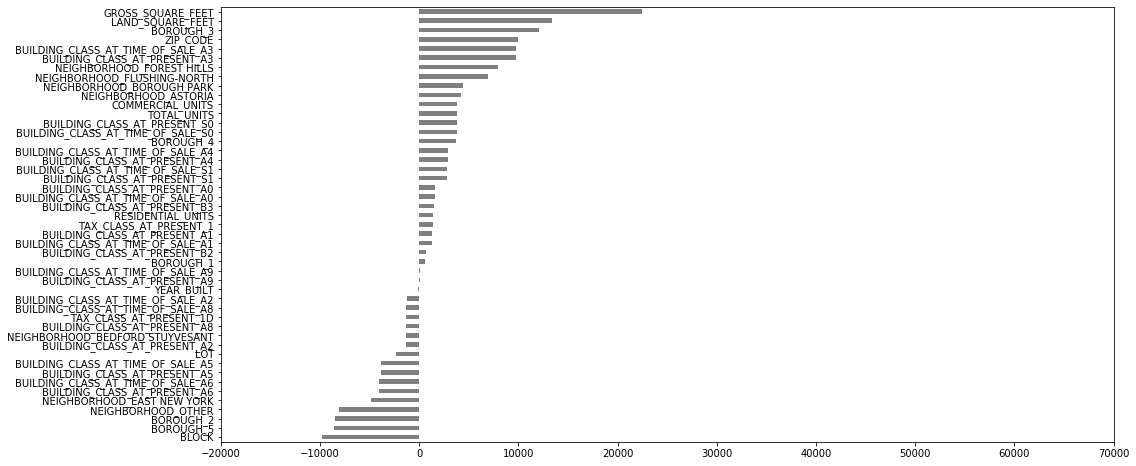

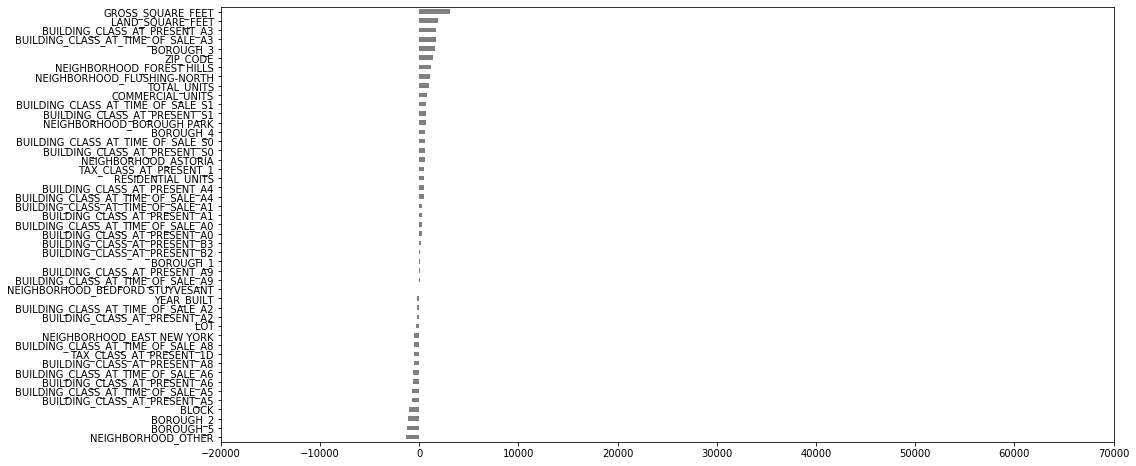

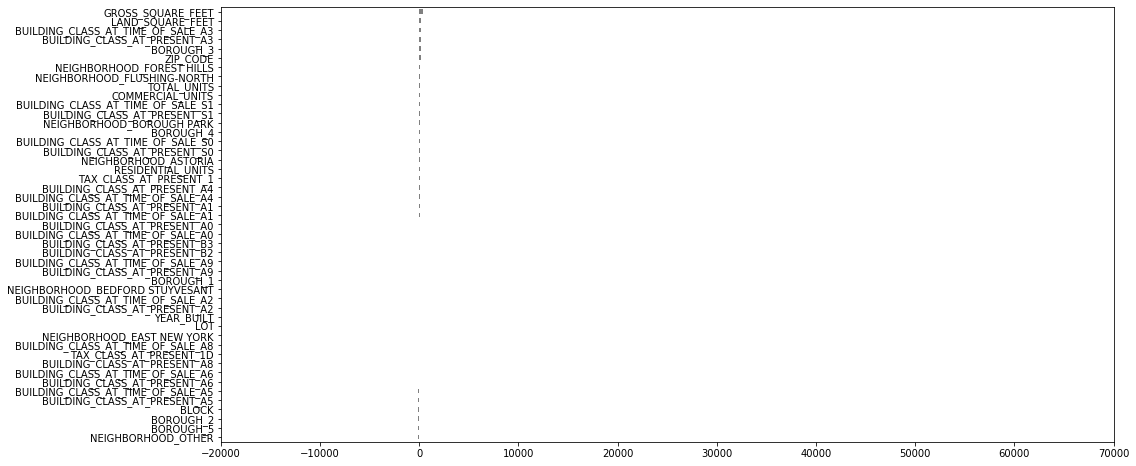

In [55]:
# Try a range of alphas for ridge regression
for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]:

  # Scale data
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  # Fit ridge regression model
  display(HTML(f'Ridge Regression, with alpha={alpha}'))
  model = Ridge(alpha=alpha)
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)

  # Get test MAE
  mae = mean_absolute_error(y_test, y_pred)
  display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))

  # Plot coefficients
  coefficients = pd.Series(model.coef_, X_train.columns)
  plt.figure(figsize=(16,8))
  coefficients.sort_values().plot.barh(color='grey')
  plt.xlim(-20000,70000)
  plt.show()